# Tech test

The aim of this test is to evaluate some of the skills that you will use on your day-to-day activies at Sensyne Health.
We collaborate as a team and the output of the Analytics side of the team has to be usable by others who might not necessarily be fluent in ML-ese.
The aim of this task is to complete the assignment by focussing on key elements such as code reusability, clarity, conciseness, and use of best practices.

In order to complete this assignment please consider the following classification problem given the dataset below (you are free to add and remove steps as you feel is required). 

Data contains information about mothers who may or may not develop diabetes (Outcome).

1. Explore the data, identify and clarify any assumption you will make
2. Consider any change/operation you will do based on your assumptions
3. Your colleagues have used a Logistic regression classifier. Review the code and apply all the changes that you feel are required
4. Compare this outcome with other two classifiers. Which one is the best out of the three?
5. You are afraid of overfitting. How do you adjust your program to take care of that?
6. Which classifier would you pick?

At every step, git commit a different version of the Notebook to show the changes. Please do so on a local git repository. Don't worry about branches.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as rnd # this is an unusual way of importing this--I would consider just import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy import stats



np.random.seed(int(rnd.random()*10000000))
dataset = pd.read_csv("./dataset.csv")

## Question
Can you please explore the data and provide some valid assumptions on them?

One of the main assumptions I am making is that the samples are independent.  There really isn't a good way for me to test this based on the features provided.

There are a lot of missing values for some of the features.  One assumption is that these data are missing at random.  A full discussion of this problem is outside the scope of this tech test, but we can look to see how these values are distributed with respect to the outcome variable (which itself is somewhat imbalanced):

In [2]:
dataset.groupby('Outcome').agg(lambda x: len(x) - x.astype(bool).sum(axis=0))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,73,3,19,139,236,9.0,0.0,0
1,38,2,16,88,138,2.0,0.0,0


Generally speaking, these missing values (0s in this dataset) are distributed roughly in proportion to the outcome measure (about 2 to 1--i.e., there are about twice as many non-diabetes as diabetes outcomes).

Looking at histograms of the individual features, we can see that a number of them are not normally distributed--though this is not a problem for logistic regression, it is for the regularization if used:

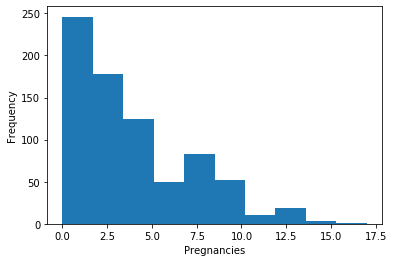

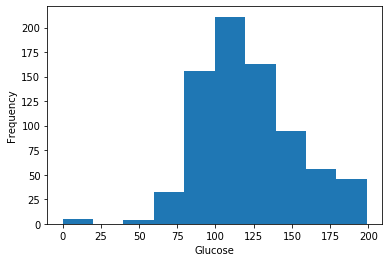

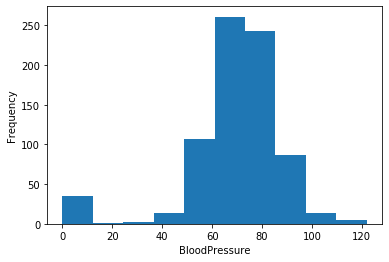

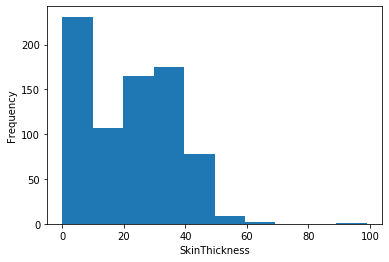

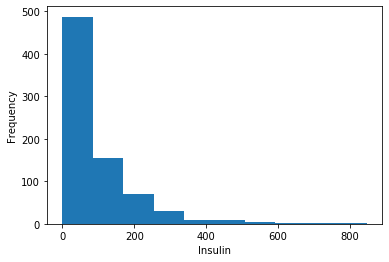

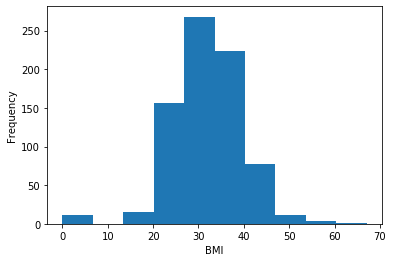

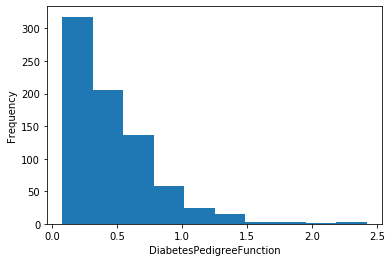

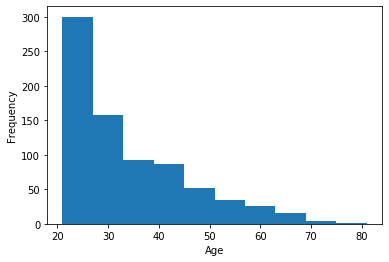

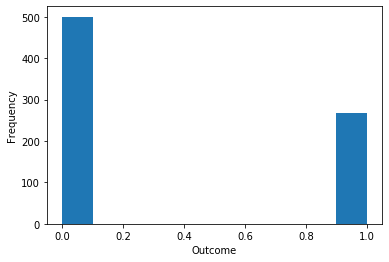

In [3]:
for col in dataset.columns:
    fig,ax=plt.subplots()
    dataset[col].plot.hist(ax=ax)
    ax.set_xlabel(col)

Another assumption of logistic regression is no multicollinearity.  We can some idea of this by looking at the heatmap of correlations between features.  We drop the outcome as we will look at that using point-biserial correlation.  Because of the large number of zeros, we really need to do some sort of imputation before we look at this, because we will be feeding our models imputed data.  

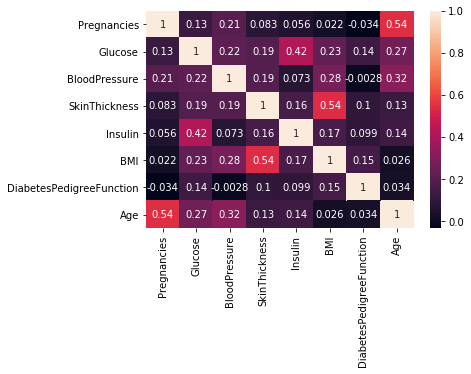

In [4]:
import seaborn as sns
from sklearn.impute import SimpleImputer
imp = SimpleImputer()
cols_with_missing = ['Glucose', 'BloodPressure', 'BMI', 'Insulin', 'SkinThickness']
dataset.loc[:,cols_with_missing] = dataset.loc[:,cols_with_missing].replace({0:np.nan})
dataset_arr = imp.fit_transform(dataset)
dataset.loc[:,:] = dataset_arr
corr_mat = dataset.drop(columns=['Outcome']).corr()
sns.heatmap(corr_mat, annot=True)

There is a high and somewhat understandable relationship between Age and number of pregnancies.  Otherwise, no serious problems.  We can test for multicollinearity by looking at the variance inflation factor (VIF):

In [5]:
X = dataset.drop(columns=['Outcome'])
X.loc[:,'const'] = 1

vif = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

vif.drop('const')

Pregnancies                 1.429998
Glucose                     1.353074
BloodPressure               1.239114
SkinThickness               1.451069
Insulin                     1.231335
BMI                         1.567784
DiabetesPedigreeFunction    1.045751
Age                         1.618502
dtype: float64

These values are all completely fine.

In [6]:
for col in dataset.columns:
    r,p = stats.pointbiserialr(dataset['Outcome'].values, dataset[col].values)
    print('{}: r value is {}, p={}'.format(col,r,p))

Pregnancies: r value is 0.22189815303398677, p=5.065127298051538e-10
Glucose: r value is 0.4929276676125099, p=2.9092516568454674e-48
BloodPressure: r value is 0.16607366868294884, p=3.709288185092262e-06
SkinThickness: r value is 0.21529921087156037, p=1.6635499719916702e-09
Insulin: r value is 0.21441095278758565, p=1.9467180024263518e-09
BMI: r value is 0.31192438850062654, p=8.595300884272788e-19
DiabetesPedigreeFunction: r value is 0.17384406565296007, p=1.254607010148255e-06
Age: r value is 0.2383559830271978, p=2.209975460664566e-11
Outcome: r value is 1.0, p=0.0


Almost all of the predictors have a significant relationship to the outcome variable

## Question
Anything that we need to do based on your assumptions?

We will apply PowerTransform to Age, Pedigree, Insulin and Skin Thickness.

This is a very messy way of doing a train-test split--espeicially the repeated use of magic numbers like 0.3 and 0.7. Instead we will extract a holdout set using train_test_split, then run cross validation using GridSearchCV and Pipeline.  In an ideal world we would do our imputation separately on the train and test sets to prevent leakage, but for the purposes of this test I'm going to just do it once and move on from there (and actually, it has already been done above).

In [7]:

non_normal_cols = ['Age', 'DiabetesPedigreeFunction', 'Insulin', 'SkinThickness']

powt = PowerTransformer()

dataset.loc[:, non_normal_cols] = powt.fit_transform(dataset.loc[:, non_normal_cols])

X,y = dataset.drop(columns=['Outcome']), dataset.loc[:,'Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)



## Logistic regression

Here is a function that allows us to pass a constructed classifier and a param grid to carry out cross validation and find the best parameter settings

In [11]:
def run_grid_search(classifier, params):

    search = GridSearchCV(classifier, params, n_jobs=-1, scoring='roc_auc')
    search.fit(X_train, y_train)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

    prediction_test = search.predict(X_test)
    prediction_probability_test = search.predict_proba(X_test)

    fig, ax = plt.subplots()

    metrics.plot_roc_curve(search, X_test, y_test, name= "test data", ax = ax)
    metrics.plot_roc_curve(search, X_train, y_train, name= "train data", ax = ax)
    
    return search

Best parameter (CV score=0.849):
{'C': 0.1}


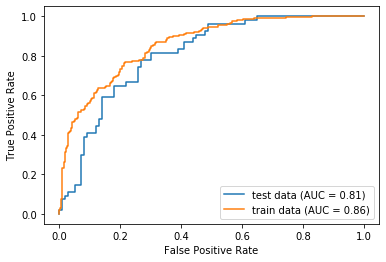

In [12]:

param_grid = {
    'C': [0.01, 0.1, 0.25, 0.5, 0.75, 1],
}

classifier = LogisticRegression(class_weight='balanced', max_iter=1000)
grid_search = run_grid_search(classifier, param_grid)